In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
measurement_pd = pd.read_sql("SELECT * FROM Measurement", engine)
measurement_pd.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [11]:
# Design a query to retrieve the last 12 months of precipitation data

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = dt.date(2017, 8, 23)

# Calculate the date 1 year ago from the last data point in the database

first_date = dt.date(2017, 8, 23)- dt.timedelta(days=365)
#2017-8-23, 2016-08-23

# Perform a query to retrieve the data and precipitation scores
twelve_months = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= first_date).\
    filter(Measurement.date <= latest_date).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
twelve_months_df = pd.DataFrame(twelve_months)
twelve_months_df.set_index('date').head(20)



,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


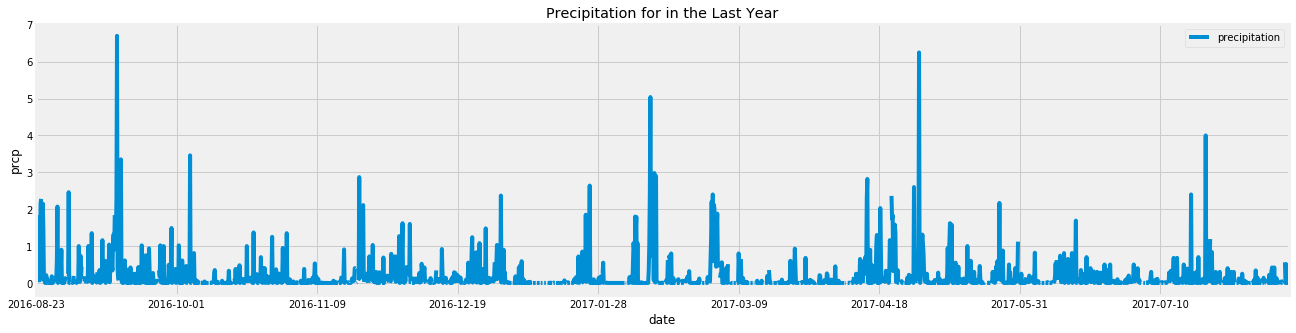

In [48]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams["figure.figsize"]= (20,5)
twelve_months_df.plot(x='date', y='prcp')
plt.title("Precipitation for in the Last Year")
plt.xlabel("date") 
plt.ylabel("prcp")
plt.legend(["precipitation"])
plt.show()


In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
twelve_months_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
stations_pd = pd.read_sql("SELECT * FROM Station", engine)
stations_pd.head(5)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [15]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.station).count()
total_stations


9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station).label('count')).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
most_active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded,highest temperature recorded,
#and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').all()
highest_temp = session.query(func.max(Measurement.tobs)).\
                 filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).\
             filter(Measurement.station == 'USC00519281').all()
                         
lowest_temp, highest_temp, avg_temp

([(54.0)], [(85.0)], [(71.66378066378067)])

In [18]:
# Choose the station with the highest number of temperature observations.
most_obs = session.query(Measurement.station, Measurement.tobs, func.count(Measurement.tobs).label('count')).\
             group_by(Measurement.station).\
             order_by(func.count(Measurement.tobs).desc()).all()
most_obs

[('USC00519281', 70.0, 2772),
 ('USC00519397', 65.0, 2724),
 ('USC00513117', 67.0, 2709),
 ('USC00519523', 75.0, 2669),
 ('USC00516128', 73.0, 2612),
 ('USC00514830', 67.0, 2202),
 ('USC00511918', 66.0, 1979),
 ('USC00517948', 75.0, 1372),
 ('USC00518838', 72.0, 511)]

In [19]:
# Query the last 12 months of temperature observation data for this station
twelve_month_tobs = session.query(Measurement.tobs).\
                      filter(Measurement.date >= first_date).\
                      filter(Measurement.date <= latest_date).\
                      filter(Measurement.station == 'USC00519281').\
                      order_by(Measurement.date).all()
twelve_month_tobs_df = pd.DataFrame(twelve_month_tobs)
twelve_month_tobs_df.head(20)


,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
5,73.0
6,78.0
7,77.0
8,78.0
9,80.0


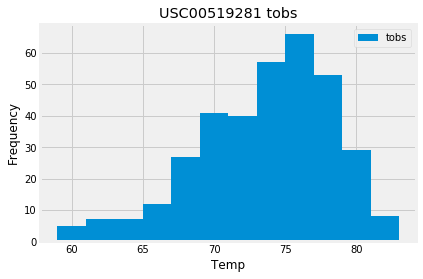

In [20]:
#plot the results as a histogram
plt.title("USC00519281 tobs")
plt.xlabel("Temp") 
plt.ylabel("Frequency")
plt.hist(twelve_month_tobs_df['tobs'], bins = 12)
plt.legend(["tobs"])
plt.show()

In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calculating_temps(first_date, last_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= first_date).filter(Measurement.date <= last_date).all()

# function usage example
print(calculating_temps('2016-08-23', '2017-08-23'))

Tmax=87.0
Tmin=58.0
Tavg=74.59058295964125

[(58.0, 74.59058295964125, 87.0)]


In [22]:
Yerrorvalue = Tmax-Tmin
Yerrorvalue

29.0

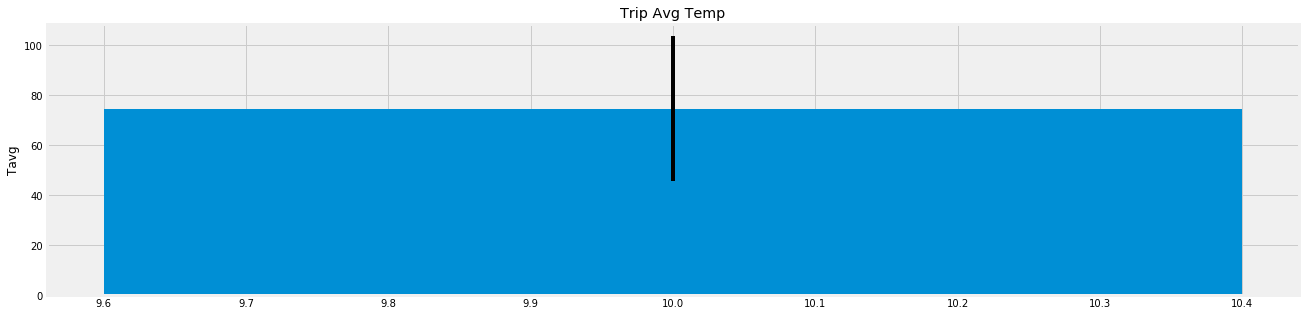

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


plt.title("Trip Avg Temp")
plt.bar(10, Tavg, yerr=Yerrorvalue)
plt.ylabel('Tavg')

plt.show()

In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall= session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation,func.sum(Measurement.prcp).label('total')).\
                filter(Measurement.date >= first_date).\
                filter(Measurement.date <= latest_date).\
                group_by(Measurement.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()
total_rainfall_df=pd.DataFrame(total_rainfall)
total_rainfall_df.head(10)

,station,name,latitude,longitude,elevation,total
0,USC00516128,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,1330.29
1,USC00519281,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,630.27
2,USC00513117,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,436.59
3,USC00519523,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,342.09
4,USC00514830,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,299.16
5,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,144.81
6,USC00517948,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,41.31


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
